In [1]:
import os, requests, zipfile

In [2]:
# download the dataset
modelnet_url = "http://vision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip"
if not os.path.isfile("data/ModelNet10.zip"):
    r = requests.get(modelnet_url, allow_redirects=True)
    with open("data/ModelNet10.zip", "wb") as file:
        file.write(r.content)
    
if not os.path.exists("data/ModelNet10"):
    zfile = zipfile.ZipFile("data/ModelNet10.zip")
    zfile.extractall("data/")

In [3]:
# now generate the labels
data_dir = "data/ModelNet10/"
classes = ["bathtub", "bed", "chair", "desk", "dresser", "monitor", "night_stand", "sofa", "table", "toilet"]
groups = ["train", "test"]

for group in groups:
    with open(f"data/{group}_labels.csv", "w") as label_file:
        for i, name in enumerate(classes):
            class_dir = data_dir + name + f"/{group}"
            for filename in os.listdir(class_dir):
                if filename[0] == '.':
                    continue
                f = os.path.join(class_dir, filename)
                if os.path.isfile(f):
                    label_file.write(f"{f},{i}\r\n")
    

In [65]:
import open3d
from torch.utils.data import Dataset
import torch

def voxelgrid_to_tensor(voxelgrid, nx):
    img = torch.zeros((nx+1, nx+1, nx+1))
    for vox in voxelgrid.get_voxels():
        x, y, z = vox.grid_index
        img[x, y, z] = 1

    return img

class ModelNet(Dataset):
    def __init__(self, train=True, transform=None, nx=63):
        self.transform = transform
        self.nx = nx

        labels_file = "data/test_labels.csv"
        if train:
            labels_file = "data/train_labels.csv"
        self.labels = []
        self.ofiles = []
        with open(labels_file, "r") as f:
            for line in f:
                fname, cl = line.split(',')
                self.labels.append(int(cl))
                self.ofiles.append(fname)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        off_path = self.ofiles[idx]
        mesh = open3d.io.read_triangle_mesh(off_path)
        bounds = (min(mesh.get_min_bound()), max(mesh.get_max_bound()))
        dx = (bounds[1] - bounds[0])/(self.nx-1)
        out = open3d.geometry.VoxelGrid.create_from_triangle_mesh_within_bounds(mesh, dx, [bounds[0], bounds[0], bounds[0]], [bounds[1], bounds[1], bounds[1]])
        out = voxelgrid_to_tensor(out, self.nx)
        if self.transform:
           out = self.transform(out)
        return out, self.labels[idx]
    

In [70]:
train = ModelNet(nx=32)
img = train[1200][0]

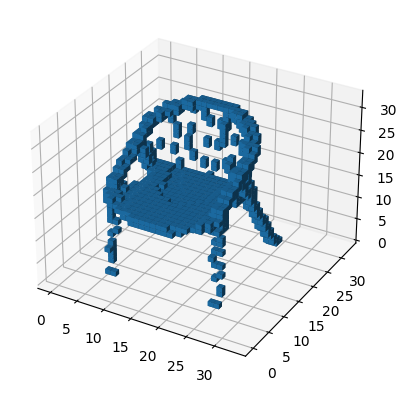

In [71]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.voxels(img)
plt.show()